# The Battle of Neighborhoods - Capstone project Warsaw flats

##### Import necessary packages

In [1]:
from bs4 import BeautifulSoup
from requests import get
import requests
import sqlite3
from sys import argv
import re
import pandas as pd
import numpy as np
import wikipedia as wp
from geopy.geocoders import Nominatim
from geopy.distance import great_circle
import folium
import json

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns
from pandas.io.json import json_normalize 

from sklearn.cluster import KMeans

### 1. Scraping local website
##### Set URL address to local website with apartments ad

In [2]:
URL = 'https://www.olx.pl/nieruchomosci/mieszkania/wynajem/warszawa/'
flats = []

In [3]:
def parse_price(price):
    return float(price.replace(' ','').replace('zł','').replace(',','.'))

In [4]:
def parse_page(pageNumber):
    print(f'Processing......... Page number {pageNumber}')
    page = get(f'{URL}?page={pageNumber}')
    bs = BeautifulSoup(page.content, 'html.parser')
    
    for offer in bs.find_all('div', class_='offer-wrapper'):
        footer = offer.find('td', class_ = 'bottom-cell')
        test = footer.find('small', class_='breadcrumb').get_text().strip().split(',')
        if (len(test)>1):
            location = footer.find('small', class_='breadcrumb').get_text().strip().split(',')[1]
            title = offer.find('strong').get_text().strip()
            price = parse_price(offer.find('p',class_='price').get_text().strip())
            
            #Processing of the ads from the pageNumber 
            link = offer.find('a')
            #print(link['href'])
            URL2 = link['href']
            page2 = get(URL2)
            bs2 = BeautifulSoup(page2.content, 'html.parser')
            offer2 = bs2.find_all('div', class_='clr descriptioncontent marginbott20')
            offer_detail_names_ = bs2.find_all('span', class_='offer-details__name')
            offer_detail_values_ = bs2.find_all('strong', class_='offer-details__value')
                
            offer_detail_names=[]
            offer_detail_values=[]
            for i in offer_detail_names_:
                offer_detail_names.append(i.contents[0])
            for i in offer_detail_values_:
                offer_detail_values.append(i.contents[0])
                    
            if 'Powierzchnia' in offer_detail_names:    
                i = offer_detail_names.index('Powierzchnia') 
                size_ = offer_detail_values[i].string
                size_ = size_[:-2]
                if ',' in size_:
                    size_ = size_.replace(',','.')
                size = float(size_)
                
                
                i = offer_detail_names.index('Liczba pokoi')
                rooms_ = offer_detail_values[i].string
                if rooms_ == 'Kawalerka':
                    rooms = 1
                else:
                    rooms_ = rooms_[:-6]
                    rooms = int(re.search(r'\d+', rooms_).group(0))
                flats.append([location,size,rooms,price,round(price/size,2)])

In [11]:
for page in range (1,26):
    parse_page(page)

Processing......... Page number 1
Processing......... Page number 2
Processing......... Page number 3
Processing......... Page number 4
Processing......... Page number 5
Processing......... Page number 6
Processing......... Page number 7
Processing......... Page number 8
Processing......... Page number 9
Processing......... Page number 10
Processing......... Page number 11
Processing......... Page number 12
Processing......... Page number 13
Processing......... Page number 14
Processing......... Page number 15
Processing......... Page number 16
Processing......... Page number 17
Processing......... Page number 18
Processing......... Page number 19
Processing......... Page number 20
Processing......... Page number 21
Processing......... Page number 22
Processing......... Page number 23
Processing......... Page number 24
Processing......... Page number 25


In [12]:
column_names = ['District', 'Size m2', 'Rooms', 'Price' , 'Price/m2']
flatsOffers = pd.DataFrame(flats, columns=column_names)
flatsOffers.head()

,District,Size m2,Rooms,Price,Price/m2
0,Włochy,49.00,2,2500.0,51.02
1,Ursus,37.07,2,1800.0,48.56
2,Białołęka,37.00,2,2300.0,62.16
3,Bielany,88.00,4,3499.0,39.76
4,Wawer,130.00,3,3500.0,26.92


In [13]:
print('There are {} flats in the dataset'.format(flatsOffers.shape[0]))

There are 989 flats in the dataset


##### Save scraping data to csv

In [16]:
flatsOffers.to_csv('flatsOffers.csv',index=False) 

##### Load data from csv

In [36]:
flatsOffers = pd.read_csv("flatsOffers.csv") 

### 2 Cleaning and visualize data

In [37]:
flatsOffers.describe()

,Size m2,Rooms,Price,Price/m2
count,989.000000,989.000000,989.000000,989.000000
mean,41.970293,1.885743,2008.408493,50.581062
std,16.142255,0.729711,721.634052,14.015332
min,10.000000,1.000000,100.000000,1.640000
25%,31.000000,1.000000,1590.000000,41.670000
50%,40.000000,2.000000,1900.000000,49.900000
75%,50.000000,2.000000,2300.000000,58.140000
max,150.000000,4.000000,10100.000000,125.000000


In [38]:
flatsOffers.dtypes

District     object
Size m2     float64
Rooms         int64
Price       float64
Price/m2    float64
dtype: object

##### Remove rows with NA values

In [39]:
flatsOffers.dropna(subset=['District', 'Size m2', 'Rooms', 'Price' , 'Price/m2'], inplace=True)
print('There are {} flats in the dataset'.format(flatsOffers.shape[0]))

There are 989 flats in the dataset


##### Let's check how many apartments per room number there is in dataset

In [40]:
flatsOffers['Rooms'].value_counts()

2    516
1    304
3    147
4     22
Name: Rooms, dtype: int64

##### We can check the number of apartments per room number and number of apartments in each district

[Text(0, 0, ' Włochy'),
 Text(0, 0, ' Ursus'),
 Text(0, 0, ' Białołęka'),
 Text(0, 0, ' Bielany'),
 Text(0, 0, ' Wawer'),
 Text(0, 0, ' Mokotów'),
 Text(0, 0, ' Ursynów'),
 Text(0, 0, ' Wola'),
 Text(0, 0, ' Żoliborz'),
 Text(0, 0, ' Targówek'),
 Text(0, 0, ' Bemowo'),
 Text(0, 0, ' Wilanów'),
 Text(0, 0, ' Ochota'),
 Text(0, 0, ' Śródmieście'),
 Text(0, 0, ' Praga-Północ'),
 Text(0, 0, ' Praga-Południe'),
 Text(0, 0, ' Wesoła'),
 Text(0, 0, ' Rembertów')]

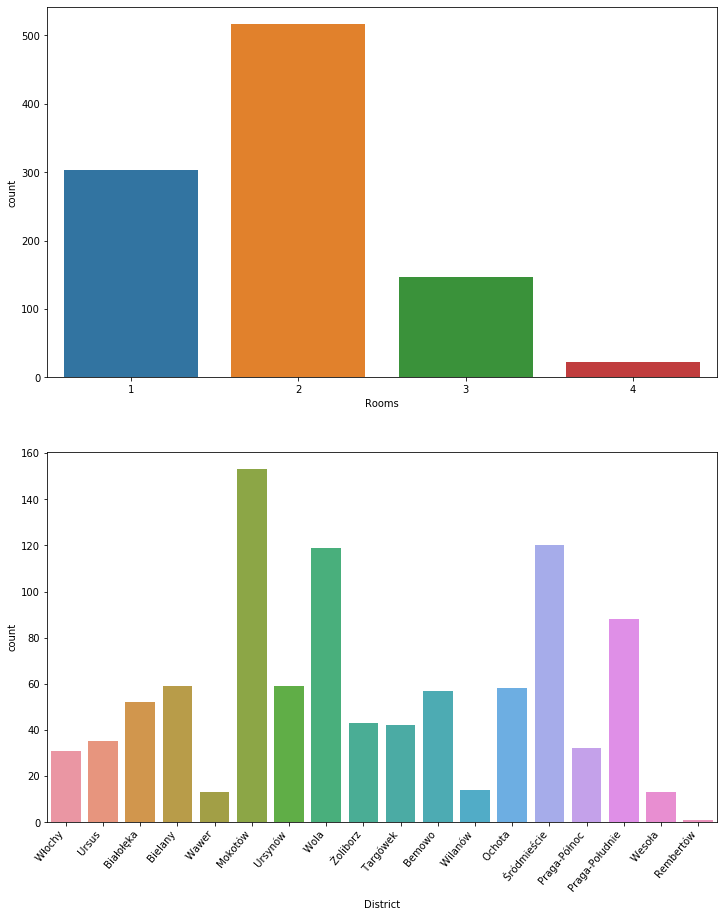

In [41]:
fig, ax =plt.subplots(2,1, figsize=(12,15))
sns.countplot(flatsOffers['Rooms'], ax=ax[0])
sns.countplot(flatsOffers['District'], ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=50, ha="right")

##### Plot the price

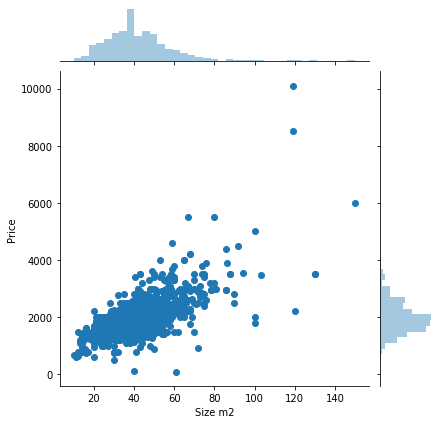

In [42]:
sns.jointplot(x='Size m2', y='Price', data=flatsOffers[['Size m2','Price']])

##### Remove the outliers

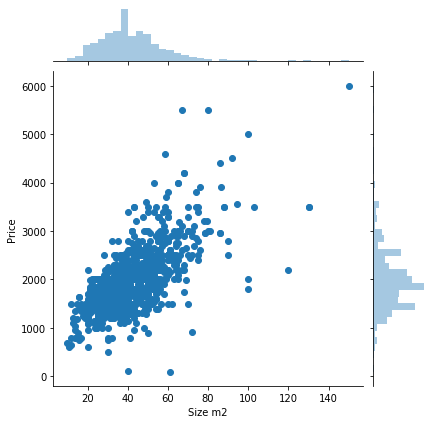

In [43]:
flatsOffers = flatsOffers[flatsOffers['Price'] <= 6000]
sns.jointplot(x='Size m2', y='Price', data=flatsOffers[['Size m2','Price']])

##### We expect the value of properties to go up as the number of rooms increases. 

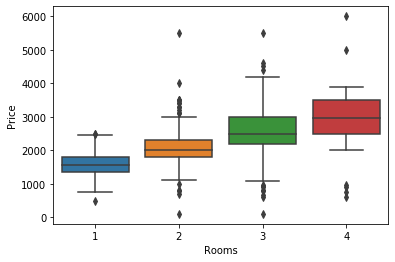

In [44]:
sns.boxplot(x='Rooms', y='Price', data=flatsOffers)

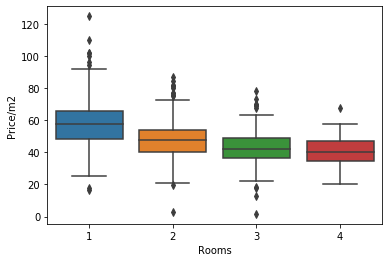

In [45]:
sns.boxplot(x='Rooms', y='Price/m2', data=flatsOffers)

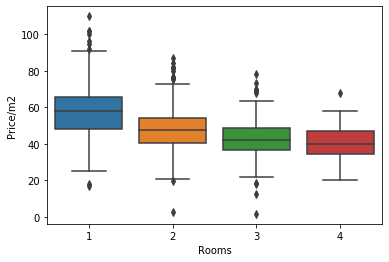

In [46]:
flatsOffers = flatsOffers[flatsOffers['Price/m2'] <= 120]
sns.boxplot(x='Rooms', y='Price/m2', data=flatsOffers)

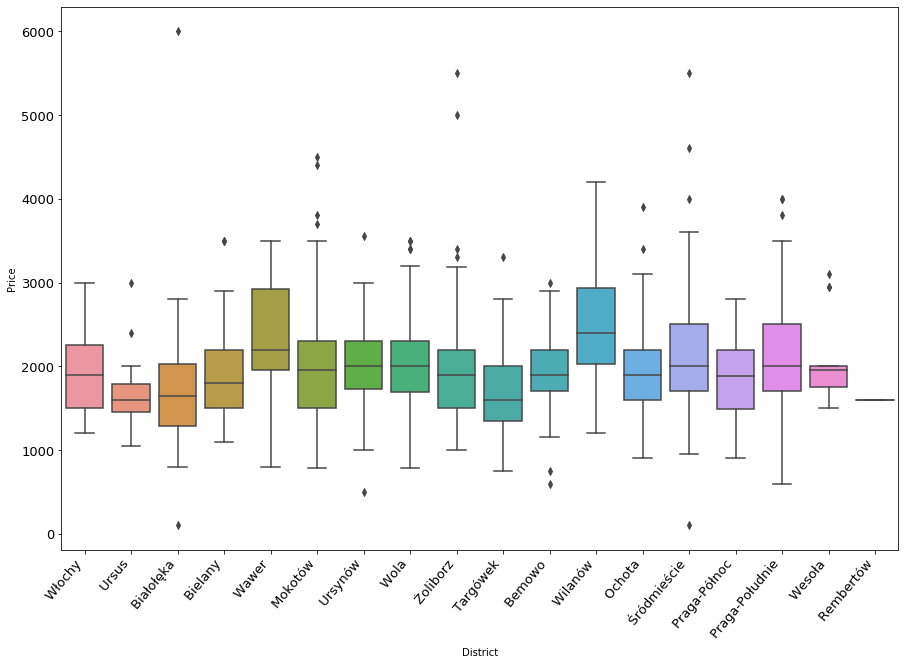

In [47]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='District', y='Price', data=flatsOffers)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.tick_params(labelsize=13)

##### Save the dataframe to a csv file

In [48]:
flatsOffers.to_csv('flatsOffersAferProcessing.csv',index=False) 

In [49]:
flatsOffers = pd.read_csv("flatsOffersAferProcessing.csv") 
flatsOffers.head()

,District,Size m2,Rooms,Price,Price/m2
0,Włochy,49.00,2,2500.0,51.02
1,Ursus,37.07,2,1800.0,48.56
2,Białołęka,37.00,2,2300.0,62.16
3,Bielany,88.00,4,3499.0,39.76
4,Wawer,130.00,3,3500.0,26.92
